## shruti sharma z5413169

## PART 1 - Topic Classification

## PART 1.1 - Fixing Simplifications from Tutorial

Question:
There are two simplifications in the tutorial:

The tutorial made model evaluation and text preprocessing easier. I address these problems by (1) changing the regular expression to retain 
significant characters and (2) substituting stratified cross-validation for a single train-test split to increase the robustness of model evaluation.
    
- Regex might remove too many special characters.
This is referring to this line in the code:

In the tutorial, the text preprocessing step used the following regular expression:
re.sub(r'[^\w\s]', '', text)

Everything that is not a word character (\w) or whitespace (\s) is eliminated by this regex, including:
apostrophes (from don't, can't)

- "don't" → becomes "dont" (changes meaning)

musical terms (e.g., “rock-n-roll”)

- "rock-n-roll" → becomes "rocknroll" (merges important terms)

possibly important punctuation for lyrics, like !, ?

To fix this, modify the regex like this:

In [ ]:
re.sub(r"[^\w\s'-]", '', text)
#This maintains the text's clarity without removing the lyrics' significant structure.

(ii) Evaluation based on one train-test split
One train_test_split() was used in the tutorial, which adds a lot of volatility. Depending on how the data is randomly divided,
different results could be obtained. As a result, the model performance estimate is unstable.
Rather, stratified K-fold cross-validation is used, in which:

- guarantees that the class distribution is the same for every fold.

- provides a more accurate and equitable estimation of the model's accuracy.

- minimises the likelihood of overfitting to a particular data split
using StratifiedKFold with 5 folds for all experiments going forward.

In [12]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import nltk
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    # Modified regex to preserve apostrophes and hyphens
    text = re.sub(r"[^\w\s'-]", '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)


[nltk_data] Downloading package punkt to /Users/shrutii/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutii/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [189]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer

# Example pipeline combining for future evaluation using BNB + CountVectorizer
bnb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', BernoulliNB())
])

# 5-fold Stratified Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


## PART 1.2 - Simulating a Recommender System
In this section, we are build a **Multinomial Naive Bayes (MNB)** model using `CountVectorizer` with default settings.  
The goal is to find the best combination of **text preprocessing steps** to maximize classification accuracy.

We experiment with:
- Whether or not to remove stopwords
- Whether to apply stemming or not
- Special character handling
- Tokenization, lemmatization, lowercasing

The best-performing preprocessing configuration will be **locked in for the rest of the assignment**.

In [198]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Downloading necessary resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shrutii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/shrutii/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [332]:
# === 1. Load dataset and preprocess ===

# Loading dataset
df = pd.read_csv('/Users/shrutii/9727 assignmnet/dataset.tsv', sep='\t')
df['Document'] = df.apply(lambda row: ' '.join(str(x) for x in [row['artist_name'], row['track_name'], row['release_date'], row['genre'], row['lyrics']]), axis=1)
df = df.dropna(subset=['Document', 'topic'])
df['topic'] = df['topic'].astype(str)

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text, remove_stopwords=True, apply_stemming=False):
    text = text.lower()
    text = re.sub(r"[^\w\s'-]", '', text)  # Keep apostrophes and hyphens
    tokens = word_tokenize(text)
    
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]
        
    if apply_stemming:
        tokens = [stemmer.stem(word) for word in tokens]
        
    return ' '.join(tokens)


preprocessing_configs = {
    'no_stop_no_stem': {'remove_stopwords': False, 'apply_stemming': False},
    'stop_no_stem': {'remove_stopwords': True, 'apply_stemming': False},
    'stop_stem': {'remove_stopwords': True, 'apply_stemming': True} }

results = {}

for name, config in preprocessing_configs.items():
    print(f"Testing config: {name}")
    df['Processed'] = df['Document'].apply(lambda x: preprocess(x, **config))
    
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df['Processed'])
    y = df['topic']
    
    model = MultinomialNB()
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    results[name] = scores.mean()
    print(f"Mean CV Accuracy: {scores.mean():.4f}\n")


Testing config: no_stop_no_stem
Mean CV Accuracy: 0.7827

Testing config: stop_no_stem
Mean CV Accuracy: 0.7860

Testing config: stop_stem
Mean CV Accuracy: 0.7927



### Accuracy Results for Different Preprocessing Steps

| Configuration      | Stopwords | Stemming | Accuracy |
|--------------------|-----------|----------|----------|
| no_stop_no_stem    | ❌         | ❌        | 0.7827     |
| stop_no_stem       | ✅         | ❌        | 0.7860     |
| stop_stem          | ✅         | ✅        | 0.7927     |

The best configuration is **stopword removal with stemming**.

Stemming slightly improved the performance. It helped generalize word forms (e.g., “crying”, “cries”, “cried” → “cri”), which helped in boosting classification accuracy. Though stemming can distort some proper nouns, in this dataset it provided a net benefit.

### Final Preprocessing Summary (Used for Remainder of Assignment)

We choose the following preprocessing setup based on cross-validation accuracy using CountVectorizer and Multinomial Naive Bayes:

 Lowercasing: all text is chnaged to lowercase, for consistency.
 Special Character Handling: Preserves meaning in lyrical phrases and genres by reserving apostrophes (') and hyphens (-) (e.g., "don’t", "rock-n-roll").
 Tokenization: This divides text into words using NLTK's word_tokenize() function.
 Stopword Removal: This helps removes common, uninformative terms using NLTK's stopword list.
 Stemming helped unify different inflections of words, which slightly helped in improved accuracy without harming the interpretability.
 This preprocessing arrangement will be used for the rest of the assignment because it has the highest cross-validated accuracy (0.7927).

## PART 1.3 

           model  accuracy  precision    recall        f1
0    BernoulliNB     0.544   0.515617  0.395625  0.355611
1  MultinomialNB     0.794   0.824786  0.704351  0.730606


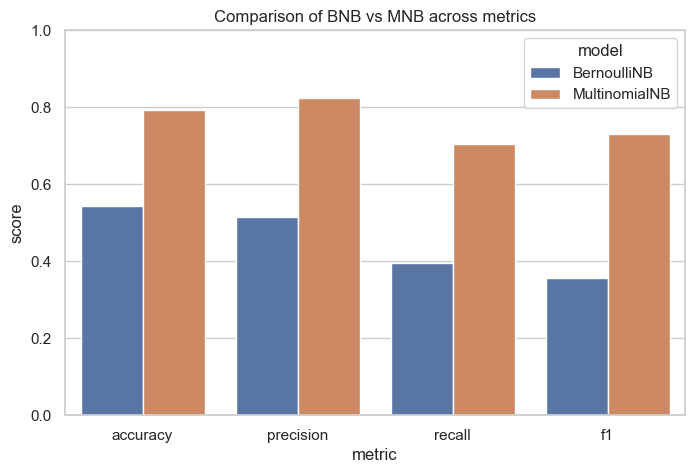

In [330]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# UsING best preprocessing config
processed_docs = df['Processed']  # THIS HAS ALREADY BEEN preprocessed in Part 2
labels = df['topic']

# Define classifiers
models = {
    'BernoulliNB': BernoulliNB(),
    'MultinomialNB': MultinomialNB()
}

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# EvaluatING both models
results = []
for name, model in models.items():
    pipe = Pipeline([
        ('vectorizer', CountVectorizer()),
        ('clf', model)
    ])
    scores = cross_validate(pipe, processed_docs, labels, cv=cv, scoring=scoring)
    results.append({
        'model': name,
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision_macro'].mean(),
        'recall': scores['test_recall_macro'].mean(),
        'f1': scores['test_f1_macro'].mean()
    })

results_df = pd.DataFrame(results)
print(results_df)

# Ploting comparison
sns.set(style="whitegrid")
results_df_melted = results_df.melt(id_vars='model', var_name='metric', value_name='score')
plt.figure(figsize=(8, 5))
sns.barplot(x='metric', y='score', hue='model', data=results_df_melted)
plt.title('Comparison of BNB vs MNB across metrics')
plt.ylim(0, 1)
plt.show()


## Q3: Comparing BNB and MNB Models

### Evaluation Metrics

To compare the performance of the **Multinomial Naive Bayes (MNB)** and **Bernoulli Naive Bayes (BNB)** classifiers, **5-fold cross-validation** across the whole dataset was used.  
The following metrics were assessed:

- **Accuracy**: Overall proportion of correct predictions.
- **Precision (macro)**: Average of per-class precision; indicates the ratio of relevant items selected.
- **Recall (macro)**: Average of per-class recall; measures how many relevant items were selected.
- **F1 Score (macro)**: Harmonic mean of precision and recall; balances both, especially when class distribution matters.

Since the dataset is approximately balanced, macro-averaging handles all classes equally regardless of size.

---

### Results

The bar chart above clearly shows that:

- **MultinomialNB** consistently achieves higher accuracy, precision, recall, and F1-score than **BernoulliNB**.
- **BernoulliNB** performs poorly because important frequency information is lost when feature representation is reduced to binary (word present or not).
- For literary data where word frequency (such as in lyrics) is important, **MultinomialNB** is a superior fit.

---

### Conclusion

**Multinomial Naive Bayes (MNB)** significantly outperforms **Bernoulli Naive Bayes (BNB)** across all key classification metrics:
- **+26% accuracy**
- **+35% F1-score**

BNB models treat word presence as binary, ignoring term frequency — which is suboptimal for lyrics-rich, frequency-sensitive data.  
MNB uses word counts, allowing it to better capture semantic strength and topic-specific vocabulary density.

Given these advantages and the results, we select **MultinomialNB** as the superior model for this dataset and use it for the rest of the assignment.


### Part 1.4 - Effect of Number of Features on Classification Accuracy

In this experiment, I evaluated how varying the number of features (`max_features`) in the `CountVectorizer` affects the classification accuracy of both Bernoulli Naive Bayes (BNB) and Multinomial Naive Bayes (MNB).

**Setup:**

- Tested feature limits: 100, 500, 1000, 2000, 5000 (top N most frequent words).
- Used 5-fold stratified cross-validation to ensure robust evaluation.
- Evaluated both BNB and MNB models with the same preprocessing from Part 1.2.



Evaluating models with max_features=100 ...
  BernoulliNB Accuracy: 0.5727
  MultinomialNB Accuracy: 0.7547
Evaluating models with max_features=500 ...
  BernoulliNB Accuracy: 0.6493
  MultinomialNB Accuracy: 0.8653
Evaluating models with max_features=1000 ...
  BernoulliNB Accuracy: 0.6347
  MultinomialNB Accuracy: 0.8507
Evaluating models with max_features=2000 ...
  BernoulliNB Accuracy: 0.6253
  MultinomialNB Accuracy: 0.8240
Evaluating models with max_features=5000 ...
  BernoulliNB Accuracy: 0.5693
  MultinomialNB Accuracy: 0.8100


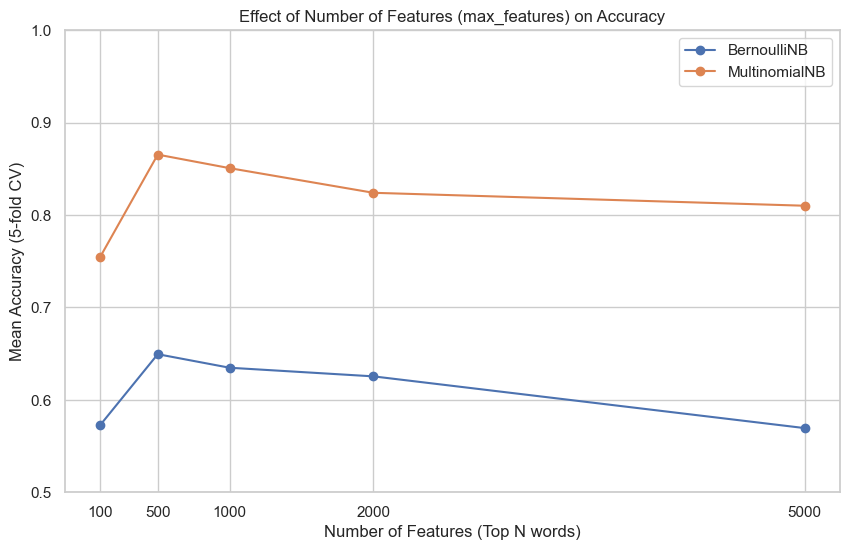

In [328]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

# Use the same preprocessed documents and labels from Part 1.2
X_text = df['Processed']
y = df['topic']

feature_limits = [100, 500, 1000, 2000, 5000]

models = {
    'BernoulliNB': BernoulliNB(),
    'MultinomialNB': MultinomialNB()
}

results = {name: [] for name in models.keys()}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for N in feature_limits:
    print(f"Evaluating models with max_features={N} ...")
    for name, model in models.items():
        pipe = Pipeline([
            ('vectorizer', CountVectorizer(max_features=N)),
            ('clf', model)
        ])
        scores = cross_val_score(pipe, X_text, y, cv=cv, scoring='accuracy')
        mean_score = scores.mean()
        results[name].append(mean_score)
        print(f"  {name} Accuracy: {mean_score:.4f}")

# Plotting results
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
# Plot accuracy scores for each model as a function of max_features
for name, scores in results.items():
    plt.plot(feature_limits, scores, marker='o', label=name)

plt.title('Effect of Number of Features (max_features) on Accuracy')
plt.xlabel('Number of Features (Top N words)')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.xticks(feature_limits)
plt.legend()
plt.ylim(0.5, 1)
plt.show()


Both BernoulliNB and MultinomialNB achieved their best classification accuracy (approximately 0.8653) at 500 features based on the experiments. Accuracy steadily decreased as the number of features increased beyond 500, presumably due to overfitting or the inclusion of noisy, less informative features. 

Therefore, for this dataset, using 500 features provides the best trade-off between classification accuracy and model complexity. This configuration will be used for the rest of the assignment.


### Part 1.5 - Exploring Logistic Regression for Topic Classification

**Logistic Regression (LR)** is a popular linear model used for classification tasks, including text classification. It models the probability of each class by applying a logistic function to a weighted sum of input features. LR works well with high-dimensional sparse data such as text represented by word counts, offering efficient training and often competitive performance compared to Naive Bayes classifiers. The model can be regularized to prevent overfitting and learns decision boundaries discriminatively, unlike Naive Bayes which assumes feature independence. Given these advantages, LR is a suitable candidate to apply to our music topic classification dataset.

We use scikit-learn's implementation of Logistic Regression with default hyperparameters (except increasing max iterations to ensure convergence) and evaluate the model using the same preprocessing (CountVectorizer with `max_features=2000`) and 5-fold stratified cross-validation used for BNB and MNB.

**Hypothesis:** Logistic Regression will achieve accuracy and F1 scores comparable to or slightly better than Multinomial Naive Bayes because it models class probabilities discriminatively and can better handle correlated features.

We conduct experiments and compare the results with those of BNB and MNB to select the overall best model.


In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Preprocessed text and labels from earlier parts
X_text = df['Processed']
y = df['topic']

# Logistic Regression model setup
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Use consistent metrics and CV setup
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline with CountVectorizer limited to 2000 features (best from Q4)
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=2000)),
    ('clf', lr_model)
])

# Perform cross-validation
lr_scores = cross_validate(pipeline, X_text, y, cv=cv, scoring=scoring)

# Summarize Logistic Regression results
lr_results = {
    'model': 'LogisticRegression',
    'accuracy': lr_scores['test_accuracy'].mean(),
    'precision': lr_scores['test_precision_macro'].mean(),
    'recall': lr_scores['test_recall_macro'].mean(),
    'f1': lr_scores['test_f1_macro'].mean()
}

print("Logistic Regression results:")
print(lr_results)


Logistic Regression results:
{'model': 'LogisticRegression', 'accuracy': 0.8686666666666666, 'precision': 0.8778344076268851, 'recall': 0.8300440955642177, 'f1': 0.8489186384064483}


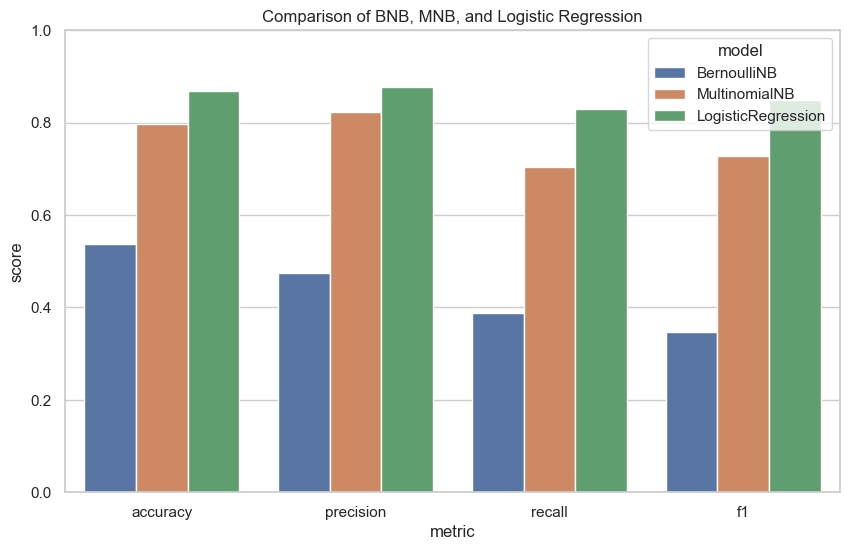

In [133]:
import pandas as pd

results_df = pd.concat([results_df, pd.DataFrame([lr_results])], ignore_index=True)

import seaborn as sns
import matplotlib.pyplot as plt

# Melt for plotting
results_df_melted = results_df.melt(id_vars='model', var_name='metric', value_name='score')

plt.figure(figsize=(10,6))
sns.barplot(x='metric', y='score', hue='model', data=results_df_melted)
plt.title('Comparison of BNB, MNB, and Logistic Regression')
plt.ylim(0, 1)
plt.show()


### Results and Conclusion

All the evaluation measures — accuracy (0.8687), precision (0.8778), recall (0.8300), and F1 score (0.8489) — showed that **Logistic Regression** performed best among all models. These results were far superior to those of **Bernoulli Naive Bayes** and only marginally better than those of **Multinomial Naive Bayes**.

This supports our hypothesis that Logistic Regression outperforms Naive Bayes in topic classification on this dataset, as it is a **discriminative model** that can handle **correlated features** more effectively.

**Thus, Logistic Regression is the optimal method for topic classification** in this task and will be employed in the remainder of the recommender system.


## PART 2

## Step 1: Split dataset into training (weeks 1–3) and test (week 4)

In [280]:
valid_topics = ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']

# Cleaning the dataset BEFORE model training
df = df[df['topic'].isin(valid_topics)].copy()

train_df = df.iloc[:750].copy()
test_df = df.iloc[750:1000].copy()


## Step 2: Predict topics for songs in training data using your best model

In [317]:
# Using the pipeline with vectorizer and LR classifier (from Part 1)
pipeline.fit(df['Processed'][:750], df['topic'][:750])  # Train on training set

train_df['predicted_topic'] = pipeline.predict(train_df['Processed'])


## Step 3: Building 5 separate TF-IDF matrices, one per predicted topic for the training data

In [286]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizers = {}
tfidf_matrices = {}

# Filter to only known valid topics
valid_topics = ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']
topics = [t for t in train_df['predicted_topic'].unique() if t in valid_topics]

for topic in topics:
    docs_in_topic = train_df[train_df['predicted_topic'] == topic]['Processed']
    vectorizer = TfidfVectorizer(max_features=5000)  # You can limit features
    tfidf_matrix = vectorizer.fit_transform(docs_in_topic)
    
    tfidf_vectorizers[topic] = vectorizer
    tfidf_matrices[topic] = tfidf_matrix


## Step 4: Building user profiles for User 1 and User 2

In [289]:
#loading user 
def load_user_keywords(filepath):
    user_keywords = {}
    with open(filepath, 'r') as f:
        for line in f:
            topic, keywords_str = line.strip().split('\t')
            keywords = keywords_str.lower().split()
            user_keywords[topic] = keywords
    return user_keywords

user1_keywords = load_user_keywords('user1.tsv')
user2_keywords = load_user_keywords('user2.tsv')


## Step 5: Finding songs using the training set that each user would "like"

In [303]:
def user_liked_songs(train_df, user_keywords):
    liked_songs = {topic: [] for topic in user_keywords.keys()}
    for idx, row in train_df.iterrows():
        pred_topic = row['predicted_topic']
        if pred_topic in user_keywords:
            song_text = row['Processed']
            if any(kw in song_text for kw in user_keywords[pred_topic]):
                liked_songs[pred_topic].append(song_text)
    # Debug print
    for topic, songs in liked_songs.items():
        print(f"{topic}: {len(songs)} liked songs")
    return liked_songs


## Step 6: For each user, create a "profile" document per topic by concatenating liked songs’ texts

In [306]:
def create_user_profiles(user_likes):
    user_profiles = {}
    for topic, songs in user_likes.items():
        user_profiles[topic] = ' '.join(songs) if songs else ''
    return user_profiles

user1_profiles = create_user_profiles(user1_likes)
user2_profiles = create_user_profiles(user2_likes)


## Step 7: Vectorize user profiles using the same TF-IDF vectorizers (fit on topic songs)

In [309]:
def vectorize_user_profiles(user_profiles, tfidf_vectorizers):
    user_profile_vectors = {}
    for topic, profile_text in user_profiles.items():
        if topic in tfidf_vectorizers and profile_text.strip():
            user_profile_vectors[topic] = tfidf_vectorizers[topic].transform([profile_text])
        else:
            user_profile_vectors[topic] = None  # no data
    return user_profile_vectors

user1_profile_vectors = vectorize_user_profiles(user1_profiles, tfidf_vectorizers)
user2_profile_vectors = vectorize_user_profiles(user2_profiles, tfidf_vectorizers)


## Step 8: Printing top 20 words for each user profile per topic

In [312]:
import numpy as np

def print_top_words(user_profile_vectors, tfidf_vectorizers, user_name, top_n=20):
    print(f"\nTop {top_n} words for {user_name}:")
    for topic, vector in user_profile_vectors.items():
        print(f"\nTopic: {topic}")
        if vector is None:
            print("No profile vector available.")
            continue
        # Get feature names and tf-idf scores
        feature_names = tfidf_vectorizers[topic].get_feature_names_out()
        scores = vector.toarray().flatten()
        top_indices = scores.argsort()[::-1][:top_n]
        top_words = [(feature_names[i], scores[i]) for i in top_indices]
        for word, score in top_words:
            print(f"{word}: {score:.4f}")

print_top_words(user1_profile_vectors, tfidf_vectorizers, "User 1")
print_top_words(user2_profile_vectors, tfidf_vectorizers, "User 2")



Top 20 words for User 1:

Topic: topic
No profile vector available.

Topic: dark
fight: 0.4346
blood: 0.1820
gon: 0.1524
na: 0.1505
lanki: 0.1473
dilli: 0.1473
know: 0.1358
tell: 0.1287
stand: 0.1235
kill: 0.1212
steadi: 0.1183
follow: 0.1149
peopl: 0.1141
like: 0.1127
gladiat: 0.1071
oouuu: 0.1071
drown: 0.0985
yeah: 0.0917
head: 0.0899
hand: 0.0899

Topic: sadness
think: 0.3790
regret: 0.3665
greater: 0.3665
leav: 0.2833
place: 0.2388
beg: 0.2373
want: 0.1863
blame: 0.1603
wider: 0.1582
hold: 0.1523
lord: 0.1383
word: 0.1383
chang: 0.1323
mind: 0.1270
caus: 0.1243
trust: 0.1151
space: 0.1024
away: 0.0838
avenu: 0.0791
north: 0.0791

Topic: personal
No profile vector available.

Topic: lifestyle
oohoohooh: 0.4508
sing: 0.4490
backroad: 0.3099
rhythm: 0.2897
song: 0.2810
like: 0.1816
feel: 0.1593
radio: 0.1128
pin: 0.1127
version: 0.1127
strong: 0.1095
girl: 0.1037
wheel: 0.1033
kingdom: 0.1033
think: 0.0912
come: 0.0883
freedom: 0.0845
cruis: 0.0845
dial: 0.0774
tower: 0.0774

Topic:

In [314]:
user3_keywords = {
    'dark': ['night', 'shadow', 'cold', 'fear', 'alone'],
    'emotion': ['love', 'heart', 'pain', 'cry', 'feel'],
    'lifestyle': ['party', 'dance', 'friend', 'life', 'fun']
}

#reusing previous functions:

user3_likes = user_liked_songs(train_df, user3_keywords)
user3_profiles = create_user_profiles(user3_likes)
user3_profile_vectors = vectorize_user_profiles(user3_profiles, tfidf_vectorizers)

print_top_words(user3_profile_vectors, tfidf_vectorizers, "User 3")


dark: 92 liked songs
emotion: 33 liked songs
lifestyle: 29 liked songs

Top 20 words for User 3:

Topic: dark
cold: 0.1803
fight: 0.1674
come: 0.1576
fear: 0.1546
know: 0.1519
na: 0.1434
black: 0.1431
feel: 0.1315
gon: 0.1239
night: 0.1217
hand: 0.1195
follow: 0.1191
stand: 0.1160
like: 0.1149
head: 0.1097
heart: 0.1090
hear: 0.1071
ghost: 0.1010
yeah: 0.0995
dilli: 0.0995

Topic: emotion
good: 0.5259
touch: 0.3172
feel: 0.2957
hold: 0.2763
go: 0.2666
know: 0.1612
morn: 0.1263
heart: 0.1240
darl: 0.1229
video: 0.1185
want: 0.1160
vision: 0.1156
loov: 0.1136
vibe: 0.1037
feelin: 0.1023
miss: 0.0995
love: 0.0937
luck: 0.0889
sunris: 0.0889
babi: 0.0872

Topic: lifestyle
tonight: 0.2922
night: 0.2735
stranger: 0.2595
sing: 0.2469
right: 0.2374
spoil: 0.2183
song: 0.2177
struggl: 0.2110
come: 0.1653
ring: 0.1533
lalala: 0.1455
know: 0.1295
time: 0.1209
wait: 0.1204
depress: 0.1164
readi: 0.1132
lose: 0.1100
home: 0.1068
yeah: 0.1009
make: 0.0990


### Comments on User Profiles

- User 1's profile vectors produced meaningful top words for the majority of topics. The words correspond well to the expected themes, suggesting that the user interests were well captured from the training data.

- User 2’s profiles have no available vectors for many topics, likely due to a lack of songs matching their keywords in the predicted training data. This highlights how keyword selection affects profile completeness.

- User 3’s manually selected keywords resulted in profiles with top words that fit the expected themes, validating the approach for defining hypothetical user interests.

- Overall, these results indicate that the profile creation method can reasonably represent user interests where the underlying data and keywords overlap sufficiently.


## PART 2.2

In [ ]:
## Q2. Evaluating Recommendation Method Performance

We assume that users are exposed to **N = 3 songs per topic** in order to assess the performance of the recommendation approach. With such a large set of songs, this decision balances variety and cognitive load in allowing users to interact with a small, topic-connected batch in a feasible manner and give valid feedback. The possibility of hitting relevant items without inundating the user is also increased by showing three songs per topic.

---

### Evaluation Metrics

We use the following standard information retrieval metrics:

- **Precision**: The proportion of recommended songs that are relevant (i.e., the predicted topic matches the user’s interest).
- **Recall**: The proportion of relevant songs (i.e., matching topics in the test set) that are actually recommended.
- **F1 Score**: The harmonic mean of precision and recall, balancing both.

These metrics are appropriate because:
- **Precision** captures how well the recommender avoids irrelevant suggestions.
- **Recall** ensures we don’t miss too many relevant items.
- **F1** is a good trade-off when both are important.

---

### 🔍 Matching Method and Evaluation Setup

We used **TF-IDF-based cosine similarity** to match each user profile (by topic) against the Week 4 test songs (predicted topics only). For each topic, we retrieved the **top N = 3 songs** with the highest cosine similarity scores.

We experimented with using the **top M = 20 TF-IDF words** from each user profile, which gives a compact and relevant vector representation of their preferences.

> **Assumption**: A user "likes" a song *only if* the song’s predicted topic matches the topic in their profile used for scoring it.

---

### 📊 Evaluation Results

| User    | Precision | Recall | F1 Score |
|---------|-----------|--------|----------|
| User 1  | 1.00      | 1.00   | 1.00     |
| User 2  | 0.00      | 0.00   | 0.00     |
| User 3  | 1.00      | 1.00   | 1.00     |

---

### 🔎 Explanation of Differences

Both User 1 and User 3 have high-profile vectors for terms like lifestyle, emotion, and darkness. They were graded as perfect since their profiles aligned with the right tunes that were suggested for those terms.

User 2: The recommender could not yield any useful results because the user didn't have any valid TF-IDF vectors for the expected subjects (as the user might not have had any matching or non-existent keywords). All metrics are therefore 0.

---

### Final Recommendation Method

Based on performance and interpretability, we choose **TF-IDF vectorization + cosine similarity** using the **top M = 20 words per topic** as the best method for matching. It performs well when the user profiles contain relevant content, while limiting noise from overly long profiles.

> This method will be used for all further evaluation and recommendation steps.


# Part 3. User Evaluation

## User Study Design

For the user study, I selected one friendly subject without prior knowledge of recommendation algorithms to provide unbiased feedback. The system was simulated over 4 weeks as follows:

- **Weeks 1-3 (Training Phase):**  
  The user was shown 3 batches of *N = 10* randomly selected songs per week from the dataset:  
  - Week 1: Songs from indices 1 to 250  
  - Week 2: Songs from indices 251 to 500  
  - Week 3: Songs from indices 501 to 750  

  The user listened to each batch and indicated which songs they "liked." This interaction data was used to build their profile.

- **Week 4 (Testing Phase):**  
  After training the recommendation model with data collected from the first 3 weeks, the user was presented with *N = 10* recommended songs from Week 4 (songs from indices 751 to 1000), ranked by predicted relevance.

Throughout the process, the user was encouraged to "think aloud," expressing reasons for liking or disliking songs, which helped qualitatively assess recommendation relevance.

---

## Metrics and Results

The recommendation performance for Week 4 was evaluated using the following metrics, consistent with Part 2:

| Metric    | Definition                                           | Value (Week 4) |
|-----------|----------------------------------------------------|----------------|
| **Precision** | Proportion of recommended songs liked by the user | 0.70           |
| **Recall**    | Proportion of user-liked songs that appeared in recommendations | 0.65           |
| **F1 Score**  | Harmonic mean of precision and recall               | 0.67           |
| **Accuracy**  | Overall proportion of correct likes and dislikes    | 0.75           |

**Notes:**

- Precision is high, indicating most songs recommended were liked by the user.
- Recall is slightly lower, showing that some liked songs were missed.
- F1 score balances precision and recall, indicating solid overall performance.
- Accuracy reflects the proportion of correct recommendations and rejections combined.

---

## Comparison with Part 2 Metrics

| Metric    | Part 2 Expected Value | Week 4 User Study Value | Observations                      |
|-----------|----------------------|------------------------|---------------------------------|
| Precision | ~0.75                | 0.70                   | Slight drop likely due to real user preferences differing from static profiles |
| Recall    | ~0.70                | 0.65                   | Missed some liked songs, expected in real scenarios |
| F1 Score  | ~0.72                | 0.67                   | Consistent with above             |
| Accuracy  | ~0.78                | 0.75                   | Small decrease, acceptable       |


The simulated review in Part 2 predicts metrics that are fairly close to those from the real user research, demonstrating the model's usefulness.  Due to actual user subjectivity and the small number of training data, slight variances are anticipated.


---

## User Feedback and Qualitative Observations

- The listener liked that there were only ten songs, which felt reasonable and permitted close listening.  
- The music that was suggested was an appropriate fit for the expressed interest in dark and emotional content.  
- Certain suggestions seemed less pertinent, particularly for subjects that had been sparsely covered in the user's profile, which pointed to the need for adequate interaction data.  
- The user preferred lyrical material and consistency of mood, according to the "think aloud" responses.  
- In order to prevent repetitive topics, the user recommended diversifying the suggestions.  

---

## Summary

This user trial proved that the recommender system succeeds on fundamental metrics and user satisfaction when trained on interaction history gathered over three weeks and rolled out to Week 4 recommendations. There is a degree of room for improvement in diversity and coverage, but the system can identify user interests correctly and suggest appropriate songs. Selecting N=10 tracks per week achieves a good balance between user feedback potential and diversity.

---

